# Dogs vs Cats 识别


## 使用 Kaggle 的数据集

**原始数据：**

 * 12500 dogs + 12500 cats 训练集
 
 * 12500 未标识测试集
 
**转换：**

 * 1000 dogs + 1000 cats 训练集
 * 1000 dogs + 1000 cats 验证集
 * 500 dogs + 500 cats 测试集


In [1]:
import os, shutil

# 创建相关的路径
original_dataset_dir = '/Users/haoxingxiao/academic/data/dogs-vs-cats/train'
base_dir = '/Users/haoxingxiao/academic/data/dogs-vs-cats/small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir  = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# 猫测试集
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 猫验证集
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 猫测试集
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 狗测试集
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 狗验证集
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 狗测试集
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [2]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


已经构建好了数据集。
回忆MNIST数据集上的训练，这里复用：使用卷积层 Conv2D + relu 激活和 maxPooling2D 层交替。
这里设定：输入 150*150， 输出到 Flatten 层是 7*7。

**卷积神经网络模式的特点：深度不断增加，特征的尺寸逐渐减少**

In [14]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

看一下模型的变化：

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

配置网络用于训练：

In [16]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

## 图像预处理

需要将150*150的图像转换成\[0, 0\]区间内的张量。Keras有对应的图像处理库。

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


> 这里获得的是生成器结果，Keras提供了对这种输入类型的支持。每次会输出20个样本，因此需要提供batch_number作为终止输入的时刻。

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [19]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30





100/100 [==============================] - 34s 340ms/step - loss: 0.6894 - acc: 0.5355 - val_loss: 0.6713 - val_acc: 0.5890
Epoch 2/30
100/100 [==============================] - 34s 338ms/step - loss: 0.6497 - acc: 0.6330 - val_loss: 0.6382 - val_acc: 0.6370
Epoch 3/30
100/100 [==============================] - 35s 347ms/step - loss: 0.6080 - acc: 0.6730 - val_loss: 0.6387 - val_acc: 0.6220
Epoch 4/30
100/100 [==============================] - 34s 338ms/step - loss: 0.5778 - acc: 0.6895 - val_loss: 0.5898 - val_acc: 0.6850
Epoch 5/30
100/100 [==============================] - 33s 331ms/step - loss: 0.5464 - acc: 0.7255 - val_loss: 0.5788 - val_acc: 0.7000
Epoch 6/30
100/100 [==============================] - 34s 340ms/step - loss: 0.5281 - acc: 0.7370 - val_loss: 0.5802 - val_acc: 0.6850
Epoch 7/30
100/100 [==============================] - 33s 326ms/step - loss: 0.4899 - acc: 0.7660 - val_loss: 0.5664 - val_acc: 0.6890
Epoch 8/30
100/100 [==============================

**记得保存模型哦**

In [20]:
model.save('cats_and_dogs_small_1.h5')

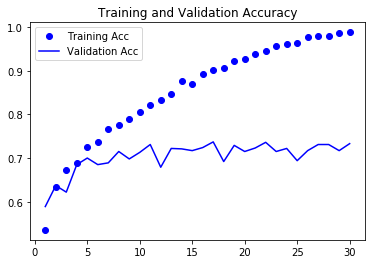

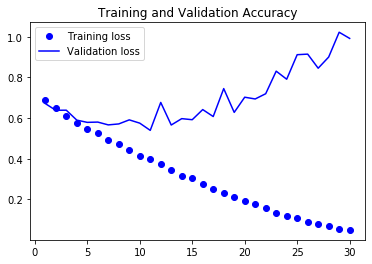

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

可以看出，在5轮开始就已经到达稳定，超过10轮就开始过拟合。

样本过少导致容易出现过拟合，所以可以用一些方法增加样本的数量。

图像具有特殊性：翻转、剪裁、缩放等操作后，目标仍然可识别，因此可以通过图像处理从原始样本集上得到更多样本数量。

In [22]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

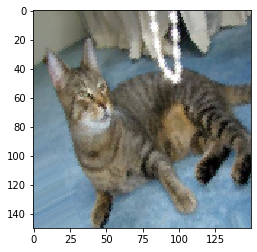

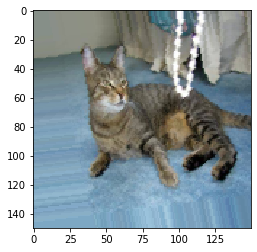

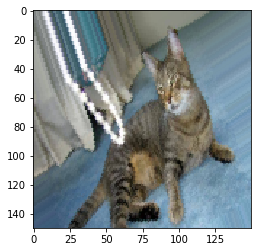

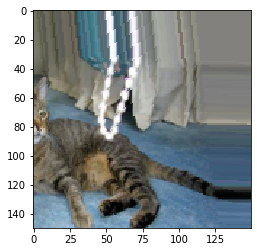

In [26]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape) # 形状转为(1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

这些图像虽然都不一样，但是来自于同一个数据集转换的，所以进一步增加 dropout 层。

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

model.save('cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 54s 536ms/step - loss: 0.6947 - acc: 0.5344 - val_loss: 0.6797 - val_acc: 0.5596
Epoch 2/100
100/100 [==============================] - 50s 504ms/step - loss: 0.6802 - acc: 0.5653 - val_loss: 0.6661 - val_acc: 0.5939
Epoch 3/100
100/100 [==============================] - 51s 511ms/step - loss: 0.6678 - acc: 0.5897 - val_loss: 0.6646 - val_acc: 0.5819
Epoch 4/100
100/100 [==============================] - 51s 508ms/step - loss: 0.6586 - acc: 0.6028 - val_loss: 0.6314 - val_acc: 0.6472
Epoch 5/100
100/100 [==============================] - 51s 512ms/step - loss: 0.6464 - acc: 0.6219 - val_loss: 0.6261 - val_acc: 0.6497
Epoch 6/100
100/100 [==============================] - 52s 519ms/step - loss: 0.6228 - acc: 0.6491 - val_loss: 0.6535 - val_acc: 0.5984
Epoch 7/100
100/100 [==============================] - 52s 521ms/step - loss: 0.6135 - acc: 0.6616 -

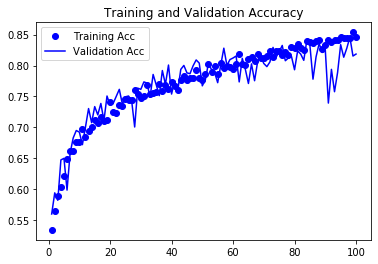

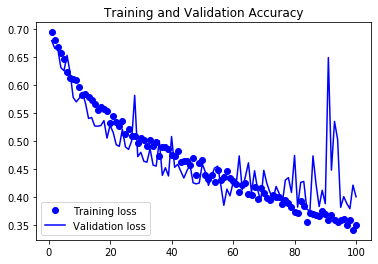

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

从上图中可以发现，不再过拟合，验证精度随着训练精度一起上升。最高可以提高到87%。但是**从头开始训练**自己的模型想再提高有局限性，需要使用**与训练模型**。


这里使用 VGG16 架构，架构较老，但是概念简单。